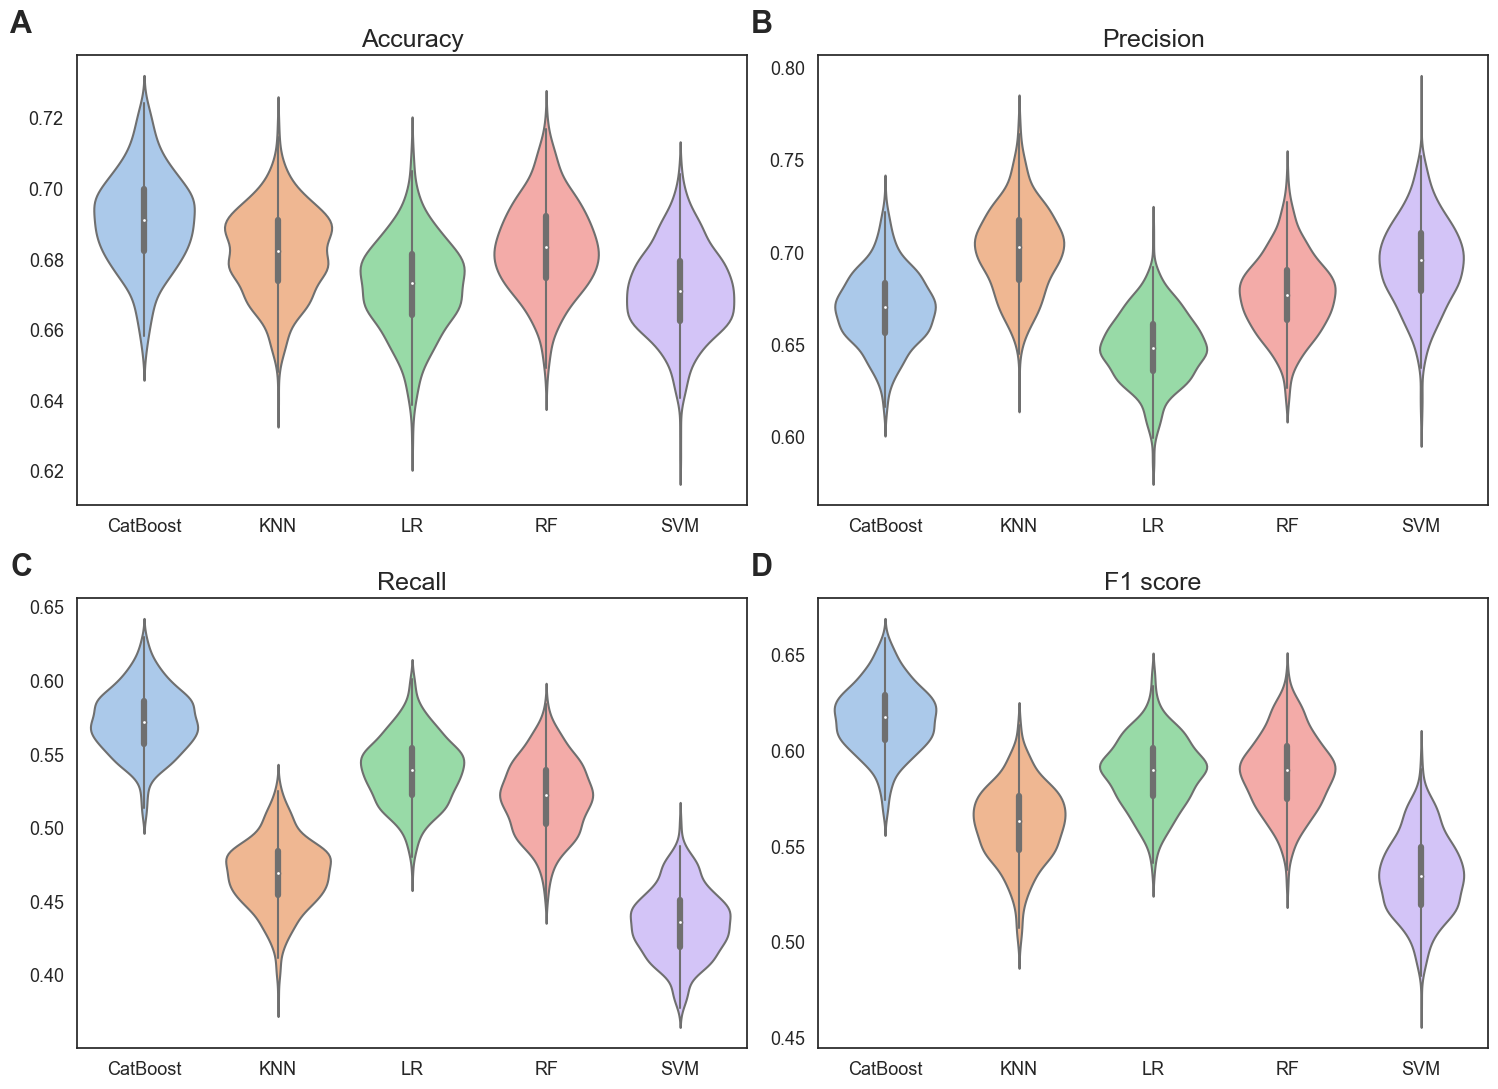

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# load data
data_accuracy = pd.read_csv('./result/5-fold-cv-Accuracy.csv')
data_precision = pd.read_csv('./result/5-fold-cv-Precision.csv')
data_recall = pd.read_csv('./result/5-fold-cv-Recall.csv')
data_f1 = pd.read_csv('./result/5-fold-cv-F1_score.csv')
# Set drawing style
sns.set(style="white")

# Create subgraph
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Use a light color palette
palette = sns.color_palette("pastel")

# Draw the graph of Accuracy
sns.violinplot(data=data_accuracy, ax=axes[0, 0], palette=palette)
axes[0, 0].text(-0.1, 1.05, 'A', transform=axes[0, 0].transAxes, size=22, weight='bold')
axes[0, 0].set_title('Accuracy', fontsize=18)
axes[0, 0].tick_params(axis='both', which='major', labelsize=13)
axes[0, 0].grid(False)

# Draw the graph of Precision
sns.violinplot(data=data_precision, ax=axes[0, 1], palette=palette)
axes[0, 1].text(-0.1, 1.05, 'B', transform=axes[0, 1].transAxes, size=22, weight='bold')
axes[0, 1].set_title('Precision', fontsize=18)
axes[0, 1].tick_params(axis='both', which='major', labelsize=13)
axes[0, 1].grid(False)

# Draw the graph of the Recall
sns.violinplot(data=data_recall , ax=axes[1, 0], palette=palette)
axes[1, 0].text(-0.1, 1.05, 'C', transform=axes[1, 0].transAxes, size=22, weight='bold')
axes[1, 0].set_title('Recall', fontsize=18)
axes[1, 0].tick_params(axis='both', which='major', labelsize=13)
axes[1, 0].grid(False)

# Draw the graph of the f1
sns.violinplot(data=data_f1, ax=axes[1, 1], palette=palette)
axes[1, 1].text(-0.1, 1.05, 'D', transform=axes[1, 1].transAxes, size=22, weight='bold')
axes[1, 1].set_title('F1 score', fontsize=18)
axes[1, 1].tick_params(axis='both', which='major', labelsize=13)
axes[1, 1].grid(False)

#  adjust the subplots spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save as an HD image
plt.savefig('./result/Training Cross-validation Metrics Comparison_violin_plot.png', dpi=300)

# show grapher
plt.show()
